In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing

#import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import warnings
warnings.filterwarnings('ignore') #to ignore warnings

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
%matplotlib inline 


In [2]:
churn_data = pd.read_csv('churn_data.csv')
customer_data = pd.read_csv('customer_data.csv')
internet_data = pd.read_csv('internet_data.csv')


In [3]:
print("churn_data :",churn_data.shape)
print("customer_data :",customer_data.shape)
print("internet_data",internet_data.shape)

churn_data : (7042, 9)
customer_data : (7042, 5)
internet_data (7042, 9)


In [4]:
# joiture avec  'customerID'
df_1 = pd.merge(customer_data,internet_data, how='inner', on='customerID')

# final database 
dataset = pd.merge(df_1, churn_data, how='inner', on='customerID')


dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,No phone service,DSL,No,Yes,No,...,No,No,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,No,DSL,Yes,No,Yes,...,No,No,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,No,DSL,Yes,Yes,No,...,No,No,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,No phone service,DSL,Yes,No,Yes,...,No,No,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,No,Fiber optic,No,No,No,...,No,No,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data cleaning


In [6]:
dataset['MultipleLines']=dataset['MultipleLines'].replace("No phone service", "No")
dataset['OnlineSecurity']=dataset['OnlineSecurity'].replace("No internet service", "No")
dataset['OnlineBackup']=dataset['OnlineBackup'].replace("No internet service", "No")
dataset['DeviceProtection']=dataset['DeviceProtection'].replace("No internet service", "No")
dataset['TechSupport']=dataset['TechSupport'].replace("No internet service", "No")
dataset['StreamingTV']=dataset['StreamingTV'].replace("No internet service", "No")
dataset['StreamingMovies']=dataset['StreamingMovies'].replace("No internet service", "No")

In [7]:
dataset[['tenure' , 'MonthlyCharges' , 'TotalCharges']].corr()

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.247701,0.825837
MonthlyCharges,0.247701,1.000000,0.650949
TotalCharges,0.825837,0.650949,1.000000


In [8]:
dataset=dataset.drop(['TotalCharges','customerID'], axis=1)

In [9]:
varlist =  [ 'PhoneService', 'PaperlessBilling', 'Churn', 'Partner', 'Dependents', 'MultipleLines',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies']

In [10]:
# definition de la map fonction
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})
def sexe(x):
    return x.map({'Male' : 1 , 'Female' : 0})

In [11]:
# application du fonction 
dataset[varlist] = dataset[varlist].apply(binary_map)
dataset[['gender']]=dataset[['gender']].apply(sexe)
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0,1,0,0,DSL,0,1,0,0,0,0,1,0,Month-to-month,1,Electronic check,29.85,0
1,1,0,0,0,0,DSL,1,0,1,0,0,0,34,1,One year,0,Mailed check,56.95,0
2,1,0,0,0,0,DSL,1,1,0,0,0,0,2,1,Month-to-month,1,Mailed check,53.85,1
3,1,0,0,0,0,DSL,1,0,1,1,0,0,45,0,One year,0,Bank transfer (automatic),42.30,0
4,0,0,0,0,0,Fiber optic,0,0,0,0,0,0,2,1,Month-to-month,1,Electronic check,70.70,1


In [3]:
#For categorical variables with multiple levels, create dummy features (one-hot encoded)
# Creating a dummy variable for some of the categorical variables and dropping the first one.
dummy1 = pd.get_dummies(dataset[['Contract', 'PaymentMethod', 'InternetService']], drop_first=True)

# addition
dataset = pd.concat([dataset, dummy1], axis=1)
dataset.head()

NameError: name 'pd' is not defined

In [13]:
dataset = dataset.drop(['Contract', 'PaymentMethod', 'InternetService'], 1)

In [14]:
#count selon le nbre de client :
dataset['Churn'].value_counts()

0    5173
1    1869
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

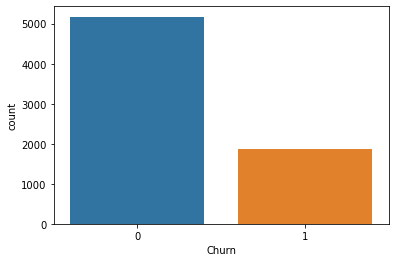

In [15]:
import seaborn as sns
sns.countplot(dataset['Churn'],label=" nbre de client :")

In [16]:
X = dataset.drop(['Churn'], axis=1)

# Putting response variable to y
y = dataset['Churn']


In [17]:
import statsmodels.api as sm
logm1 = sm.GLM(y,X, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7042
Model:                            GLM   Df Residuals:                     7020
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2925.7
Date:                Sun, 16 May 2021   Deviance:                       5851.5
Time:                        18:10:45   Pearson chi2:                 7.22e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
gender                                   -0.0195      0.065     -0.300      0.764      -0.147       0.108
SeniorCitizen                             0.2172      0.085      2.559      0.011       0.051       0.384
Partner                                  -0.0008      0.078     -0.010      0.992      -0.153       0.151
Dependents                               -0.1662      0.090     -1.854      0.064      -0.342       0.009
MultipleLines                             0.3431      0.081      4.228      0.000       0.184       0.502
OnlineSecurity                           -0.3155      0.093     -3.402      0.001      -0.497      -0.134
OnlineBackup                             -0.0670      0.084     -0.797      0.426      -0.232       0.098
DeviceProtection                          0.0457      0.086      0.532      0.595      -0.123       0.214
TechSupport                              -0.2866      0.093     -3.093      0.002      -0.468      -0.105
StreamingTV                               0.3583      0.101      3.540      0.000       0.160       0.557
StreamingMovies                           0.3729      0.102      3.643      0.000       0.172       0.573
tenure                                   -0.0341      0.002    -14.424      0.000      -0.039      -0.029
PhoneService                             -0.2983      0.217     -1.372      0.170      -0.724       0.128
PaperlessBilling                          0.3402      0.074      4.594      0.000       0.195       0.485
MonthlyCharges                           -0.0091      0.006     -1.522      0.128      -0.021       0.003
Contract_One year                        -0.6675      0.107     -6.259      0.000      -0.876      -0.458
Contract_Two year                        -1.3563      0.174     -7.796      0.000      -1.697      -1.015
PaymentMethod_Credit card (automatic)    -0.0810      0.114     -0.711      0.477      -0.304       0.142
PaymentMethod_Electronic check            0.3206      0.094      3.403      0.001       0.136       0.505
PaymentMethod_Mailed check                0.0021      0.113      0.019      0.985      -0.220       0.224
InternetService_Fiber optic               1.1282      0.170      6.627      0.000       0.794       1.462
InternetService_No                       -1.0278      0.193     -5.322      0.000      -1.406      -0.649
=========================================================================================================
"""

In [18]:
X1 = X.drop(['MonthlyCharges' , 'PaperlessBilling','PhoneService', 'PaymentMethod_Mailed check' , 'PaymentMethod_Credit card (automatic)' , 'StreamingMovies' , 'StreamingTV' , 'TechSupport' , 'DeviceProtection' , 'OnlineBackup' , 'OnlineSecurity' , 'Dependents' , 'gender' ,'Partner'  , 'MonthlyCharges'], axis=1)

#X1=dataset.drop(['MonthlyCharges' , 'PaymentMethod_Mailed check' , 'PaymentMethod_Credit card (automatic)' , 'StreamingMovies' , 'StreamingTV' , 'TechSupport' , 'DeviceProtection' , 'OnlineBackup' , 'OnlineSecurity' , 'Dependents' , 'Partner' , 'PhoneService' , 'MonthlyCharges'], 1)

In [19]:

logm1 = sm.GLM(y,X1, family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 7042
Model:                            GLM   Df Residuals:                     7034
Model Family:                Binomial   Df Model:                            7
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3023.6
Date:                Sun, 16 May 2021   Deviance:                       6047.2
Time:                        18:12:28   Pearson chi2:                 7.16e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
SeniorCitizen                      0.2760      0.082      3.357      0.001       0.115       0.437
MultipleLines                      0.2414      0.075      3.231      0.001       0.095       0.388
tenure                            -0.0389      0.002    -19.881      0.000      -0.043      -0.035
Contract_One year                 -0.8046      0.102     -7.913      0.000      -1.004      -0.605
Contract_Two year                 -1.5453      0.168     -9.183      0.000      -1.875      -1.216
PaymentMethod_Electronic check     0.2379      0.062      3.836      0.000       0.116       0.359
InternetService_Fiber optic        0.7227      0.071     10.164      0.000       0.583       0.862
InternetService_No                -1.3516      0.104    -12.939      0.000      -1.556      -1.147
==================================================================================================
"""

In [20]:
#POUR ELIMINER l'effet uniteiffaut standartiser ,'sans unite' les variables quantitatif "y-moy /ecart type" 
dataset[['tenure','MonthlyCharges']] = preprocessing.StandardScaler().fit(dataset[['tenure','MonthlyCharges']]).transform(dataset[['tenure','MonthlyCharges']])
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,...,PaperlessBilling,MonthlyCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No
0,0,0,1,0,0,0,1,0,0,0,...,1,-1.160200,0,0,0,0,1,0,0,0
1,1,0,0,0,0,1,0,1,0,0,...,0,-0.259452,0,1,0,0,0,1,0,0
2,1,0,0,0,0,1,1,0,0,0,...,1,-0.362489,1,0,0,0,0,1,0,0
3,1,0,0,0,0,1,0,1,1,0,...,0,-0.746387,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0.197570,1,0,0,0,1,0,1,0


In [21]:
# entrer les donnes en traine et test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4929, 22) (4929,)
Test set: (2113, 22) (2113,)


In [22]:
LR = LogisticRegression( solver='liblinear').fit(X_train,y_train)
predRL = LR.predict(X_test)
predpRL = LR.predict_proba(X_test)

In [27]:
f1_score(y_test,predRL , average='weighted')

0.7854823941544611

In [ ]:
Courbe ROC

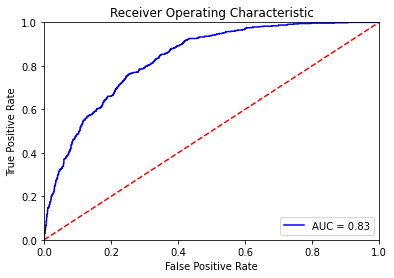

In [28]:
preds = predpRL[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_aucRL = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucRL)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [29]:
roc_aucRL

0.8330457798815485

In [30]:
from sklearn import svm
clf = svm.SVC(probability=True)
clf.fit(X_train, y_train) 
predSVM = clf.predict(X_test)
predPSVM = clf.predict_proba(X_test)

In [31]:
f1_score(y_test,predSVM, average='weighted')

0.7643977292272613

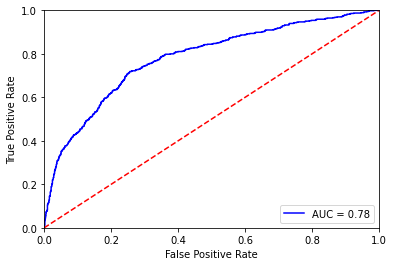

In [32]:
preds = predPSVM[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_aucSVM = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucSVM)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [33]:
roc_aucSVM

0.7796300107475247

 Arbre de decision

In [34]:
from sklearn.tree import DecisionTreeClassifier
drugTree = DecisionTreeClassifier(criterion="gini", max_depth = 4)
drugTree=drugTree.fit(X_train,y_train)

In [39]:
predTree = drugTree.predict(X_test)
predpTree = drugTree.predict_proba(X_test)

In [40]:
f1_score(y_test,predTree , average='weighted') 

0.7620164182373252

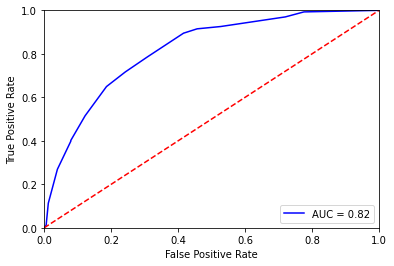

In [41]:
preds = predpTree[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_aucTree = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [42]:
roc_aucTree

0.8169324963984359

In [43]:

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
model = RandomForestClassifier(n_estimators=1000,max_depth=5)

# Train
model=model.fit(X_train, y_train)

In [44]:
y_pred = model.predict(X_test)
y_predp = model.predict_proba(X_test)

In [45]:
f1_score(y_test,y_pred , average='weighted') 

0.7637477180109292

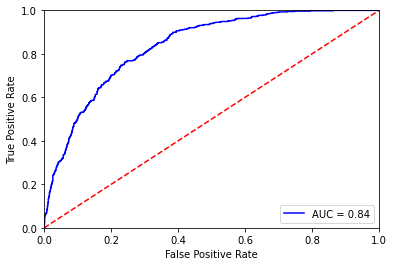

In [46]:
preds = y_predp[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_aucRF = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucRF)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
roc_aucRF

0.8368354256705769

Resume
         
         
         
Algorithm		   F1-score	    AUC
Randon Forest	   0.76		    0.83
Decision Tree	   0.76		    0.77
SVM                0.76	        0.81	
LogisticRegression 0.78 	    0.76
